# Przewidywanie zwycięzcy rundy w grze Counter Strike: Global Offensive

## Zmiany 26.05
- dodano rozdział "Optymalizacja hiperparametrów"

## Dane

Zbiór danych składa się ze snapshotów rund z około 700 meczów z profesjonalnych turniejów rozgrywanych w 2019 i 2020 roku.

Snapshoty - czyli zestawienie pewnych stanów kluczowych elementów rozgrywki - były rejestrowane podczas gry co 20 sekund aż do rozstrzygnięcia danej rundy. Łączna liczba zapisanych snapshotów wynosi 122411. Część tych rekordów będzie traktowana jako
zbiór danych uczących, a pozostała część jako część danych testów. Każdy rekord traktowany jest jako pojedynczy, niezależny element do analizy danych.

## Czym jest klasyfikator MLP?

Perceptron wielowarstwowy (MLP) to model sztucznej sieci neuronowej ze sprzężeniem do przodu, który odwzorowuje zestawy danych wejściowych na zestaw odpowiednich danych wyjściowych.

MLP składa się z wielu warstw, a każda warstwa jest w pełni połączona z następną. Węzły warstw to neurony z nieliniowymi funkcjami aktywacji, z wyjątkiem węzłów warstwy wejściowej. Pomiędzy warstwą wejściową a wyjściową może znajdować się jedna lub więcej nieliniowych warstw ukrytych.

## Import bibliotek i danych

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv('Data/csgo_round_snapshots.csv')

In [46]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [47]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [48]:
df.isnull().sum().sum()

0

In [49]:
df.shape

(122410, 97)

## Przeprocesowanie danych

W pierwszej koleności sprawdźmy liczność klas.

In [50]:
df['round_winner'].value_counts()

T     62406
CT    60004
Name: round_winner, dtype: int64

<AxesSubplot:xlabel='round_winner', ylabel='count'>

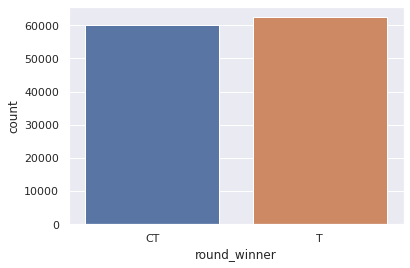

In [51]:
sns.set_theme(style="darkgrid")
sns.countplot(x='round_winner', data=df)

Następnie przekonwertujemy wszystkie kolumny na wartości liczbowe.

In [52]:
col = df.drop(df.select_dtypes(np.number), axis = 1).columns
col

Index(['map', 'bomb_planted', 'round_winner'], dtype='object')

In [53]:
lbl = LabelEncoder()
for value in col:
    df[value] = lbl.fit_transform(df[value])

In [54]:
df['bomb_planted'] = df['bomb_planted'].astype(np.int16)

In [55]:
cols = [f for f in df.columns if f not in ['round_winner']]

Dodatkowo każda wartość zostanie znormalizowana.

In [56]:
scaler = RobustScaler()

for value in cols:
    scaler = RobustScaler()
    df[value] = scaler.fit_transform(df[[value]])

Na koniec podzielimy dane na wektor danych oraz wektor wyników.

In [57]:
x = df.drop(['round_winner'], axis = 1)
y = df['round_winner']

In [58]:
len(cols)

96

Finalnie każdy rekord zawiera 96 atrybutów, które prezentują się w sposób przedstawiony poniżej.

In [59]:
x.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,0.715105,-0.857143,-0.857143,-0.666667,0.0,0.000000,0.000000,-1.291096,-1.136054,-0.112782,-0.191489,-0.5,-0.6,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
1,0.545726,-0.857143,-0.857143,-0.666667,0.0,0.000000,0.000000,0.078767,-0.115646,-0.368421,-0.395137,-0.5,-0.6,0.000000,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
2,0.010000,-0.857143,-0.857143,-0.666667,0.0,-0.726667,-0.561798,-0.284247,-0.455782,-0.357143,-0.404255,-0.5,-0.6,0.000000,-1.0,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
3,-0.168575,-0.857143,-0.857143,-0.666667,0.0,-0.726667,-0.561798,-0.284247,-0.455782,-0.357143,-0.404255,-0.5,-0.6,0.000000,-1.0,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
4,0.714837,-0.714286,-0.857143,-0.666667,0.0,0.000000,0.000000,-0.633562,-1.136054,0.966165,0.218845,-0.5,-0.6,0.000000,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0


### Wybór atrybutów

W pierwszej kolejności sprawdzimy, które atrybuty mają największy wpływ na klasy.

W tym celu wykorzystamy model *Random Forest Regressor*, który dopasowuje szereg klasyfikujących drzew decyzyjnych do różnych podpróbek zbioru danych i wykorzystuje uśrednianie w celu poprawy dokładności predykcyjnej i kontroli nadmiernego dopasowania.

In [60]:
rf = RandomForestRegressor(n_estimators=150, n_jobs=-1)
rf.fit(x, y)

RandomForestRegressor(n_estimators=150, n_jobs=-1)

Po stworzeniu i wyuczeniu modelu sortujemy tablice zawierającą informacje o tym, jak duży wpływ mają konkretne atrybuty w podejmowaniu decyzji.

In [61]:
indexes = rf.feature_importances_.argsort()

Wpływ poszczególnych atrybutów został przedstawiony na poniższym wykresie.

Text(0.5, 0, 'Feature Importance')

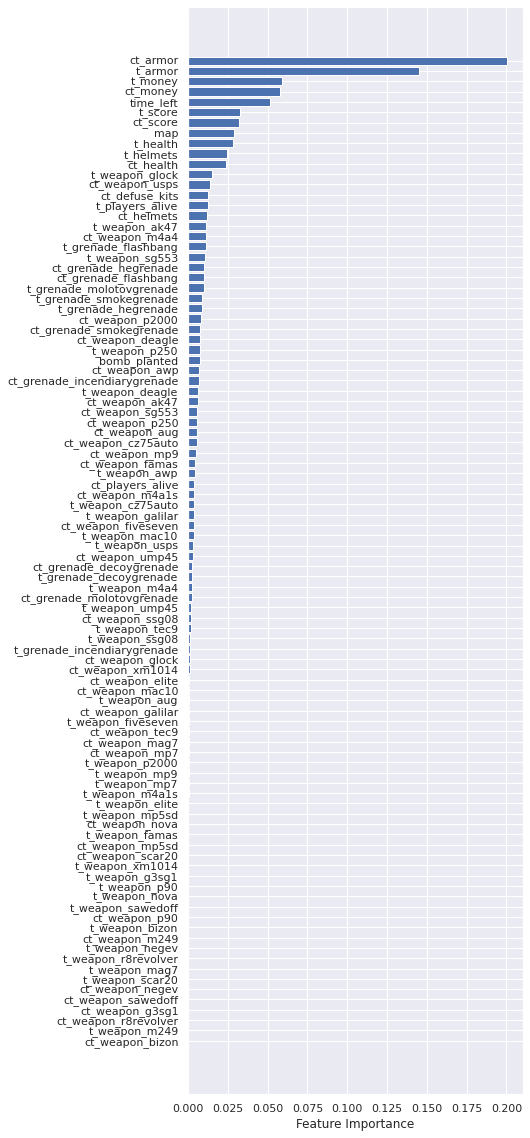

In [62]:
plt.figure(figsize=(6,20))
plt.barh(x.columns[indexes], rf.feature_importances_[indexes])
plt.xlabel("Feature Importance")

Następnie możemy odrzucić te atrybuty, które mają niski wpływ na podejmowanie decyzji lub nie mają żadnego. W tym celu wybraliśmy te atrybuty, dla których wartość parametru *feature_importance* jest większa od wartości 0,005.

In [63]:
importances = rf.feature_importances_[indexes]
indexes = indexes[np.argwhere(importances > 0.005)]
indexes = np.concatenate(indexes).ravel().tolist()
columns = x.columns[indexes]
x = x[columns]

W tym momencie możemy sprawdzić liczbę atrybutów pozostałych po selekcji.

In [64]:
x.shape

(122410, 39)

Mamy 38 atrybutów, które prezentują się jak w poniższej tabeli.

In [65]:
x.head()

,ct_weapon_mp9,ct_weapon_cz75auto,ct_weapon_aug,ct_weapon_p250,ct_weapon_sg553,ct_weapon_ak47,t_weapon_deagle,ct_grenade_incendiarygrenade,ct_weapon_awp,bomb_planted,t_weapon_p250,ct_weapon_deagle,ct_grenade_smokegrenade,ct_weapon_p2000,t_grenade_hegrenade,t_grenade_smokegrenade,t_grenade_molotovgrenade,ct_grenade_flashbang,ct_grenade_hegrenade,t_weapon_sg553,t_grenade_flashbang,ct_weapon_m4a4,t_weapon_ak47,ct_helmets,t_players_alive,ct_defuse_kits,ct_weapon_usps,t_weapon_glock,ct_health,t_helmets,t_health,map,ct_score,t_score,time_left,ct_money,t_money,t_armor,ct_armor
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,-0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,-0.333333,0.333333,0.333333,0.000000,-0.6,0.000000,-0.666667,-0.857143,-0.857143,0.715105,-0.112782,-0.191489,-1.136054,-1.291096
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,0.000000,0.333333,0.333333,0.000000,-0.6,0.000000,-0.666667,-0.857143,-0.857143,0.545726,-0.368421,-0.395137,-0.115646,0.078767
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,-1.0,0.000000,0.333333,0.000000,-0.726667,-0.6,-0.561798,-0.666667,-0.857143,-0.857143,0.010000,-0.357143,-0.404255,-0.455782,-0.284247
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,-0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,-1.0,0.000000,0.333333,-0.333333,-0.726667,-0.6,-0.561798,-0.666667,-0.857143,-0.857143,-0.168575,-0.357143,-0.404255,-0.455782,-0.284247
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,-0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,0.000000,0.333333,0.333333,0.000000,-0.6,0.000000,-0.666667,-0.714286,-0.857143,0.714837,0.966165,0.218845,-1.136054,-0.633562


Mając już przetworzone dane, możemy wydzielić z nich zbiór treningowy oraz testowy.

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.1, random_state = 0)

In [67]:
x_train.shape

(110169, 39)

In [68]:
x_test.shape

(12241, 39)

Jak widać na podstawie powyższych wywołań, mamy 110169 rekordów w zbiorze testowym oraz 12241 w zbiorze treningowym. W tym momencie możemy rozpocząć inicjalizacje modelu.

### Model MLP

W celu inicjalizacji modelu zostanie wykorzystany klasyfikator MLP, zaimplementowany w bibliotece *scikit-learn* jako *MLPClassifier*.

*MLPClassifier* określa wielowarstwowy perceptron. W przeciwieństwie do innych algorytmów klasyfikacji, takich jak klasyfikator wektorów wspierających lub naiwny klasyfikator Bayesa, *MLPClassifier* przy wykonaniu zadania klasyfikacji opiera się na podstawowej sieci neuronowej.

Istotne cechy wielowarstwowego perceptronu MLP w bibliotece *scikit-learn*:
- w warstwie wyjściowej nie ma funkcji aktywacji,
- w przypadku scenariuszy regresji błąd kwadratowy jest funkcją straty, a entropia krzyżowa jest funkcją straty klasyfikacji,
- może pracować z regresją pojedynczych, jak i wielu wartości docelowych,
- w przeciwieństwie do innych popularnych pakietów, implementacja MLP w *scikit* nie obsługuje GPU.
- nie jest możliwe dostrojenie parametrów, takich jak różne funkcje aktywacji, inicjatory wagi itp. dla każdej warstwy.

In [69]:
nn_clf = MLPClassifier(verbose = True)

Opcja *verbose=True* powoduje, że na standardowe wyjście będą drukowane wiadomości o postępach w kolejnych iteracjach.

Następnie przechodzimy do dopasowania modelu do macierzy danych *x_train* i wyniku *y_train*.

In [70]:
nn_clf.fit(x_train, y_train)

Iteration 174, loss = 0.38083043
Iteration 175, loss = 0.38038780
Iteration 176, loss = 0.38043854
Iteration 177, loss = 0.38013579
Iteration 178, loss = 0.38053035
Iteration 179, loss = 0.38020564
Iteration 180, loss = 0.38062112
Iteration 181, loss = 0.38017966
Iteration 182, loss = 0.37988326
Iteration 183, loss = 0.37956153
Iteration 184, loss = 0.38021732
Iteration 185, loss = 0.37978704
Iteration 186, loss = 0.37903529
Iteration 187, loss = 0.37995593
Iteration 188, loss = 0.37915858
Iteration 189, loss = 0.37940233
Iteration 190, loss = 0.37907956
Iteration 191, loss = 0.37899339
Iteration 192, loss = 0.37929946
Iteration 193, loss = 0.37907849
Iteration 194, loss = 0.37929303
Iteration 195, loss = 0.37901439
Iteration 196, loss = 0.37919064
Iteration 197, loss = 0.37908666
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(verbose=True)

W tym momencie możemy sprawdzić średnią trafność modelu na rozważanych danych testowych.

In [71]:
print(f'Model sieci neuronowej: {nn_clf.score(x_test, y_test)}')

Model sieci neuronowej: 0.7835144187566375


## Regresja logistyczna

Regresja logistyczna to algorytm nadzorowanego uczenia maszynowego używany do problemów z klasyfikacją binarną. Najlepszym sposobem myślenia o regresji logistycznej jest to, że jest to regresja liniowa, ale dla problemów z klasyfikacją. Podstawowa różnica między regresją liniową a regresją logistyczną polega na tym, że zakres regresji logistycznej jest ograniczony od 0 do 1. Ponadto, w przeciwieństwie do regresji liniowej, regresja logistyczna nie wymaga liniowej zależności między zmiennymi wejściowymi i wyjściowymi.

In [72]:
log_model = LogisticRegression(verbose=True, n_jobs=-1)
log_model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           40     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63633D+04    |proj g|=  1.11915D+04

At iterate   50    f=  5.26632D+04    |proj g|=  6.81933D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   40     71     77      1     0     0   1.085D+00   5.266D+04
  F =   52663.095703318511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s finished


LogisticRegression(n_jobs=-1, verbose=True)

Po wytrenowaniu modelu możemy sprawdzić jego skuteczność na danych testowych:

In [73]:
print(f"Model regresji logistycznej: {log_model.score(x_test, y_test)}")

Model regresji logistycznej: 0.7541867494485744


Regresja logistyczna okazała się trochę gorsza od modelu MLP, jednak czas trenowania modelu jest znacząco niższy.

## Optymalizacja hiperparametrów

Powyższe algorytmy MLP i LR posiadają wiele konfigurowalnych hiperparametrów. W przypadku MLP są to m.in. funkcja aktywacji `activation`, przyrost uczenia `learning_rate` oraz `solver`. Dla LR są to m.in. `multi_class` oraz `solver`.
Oczywiście dokładność modeli zależy od wartości tych hiperparametrów. W celu znalezienia kombinacji dającej najlepszej rezultaty posługujemy się biblioteką [optuna](https://optuna.readthedocs.io/en/stable/). Optymalizatory zasadniczo stale zawężają przestrzeń poszukiwań, wykorzystując zapisy sugerowanych wartości parametrów i ocenianych wartości funkcji celu, co prowadzi do optymalnej przestrzeni poszukiwań, w której uzyskuje się parametry prowadzące do lepszych wartości funkcji celu. Domyślnym optymalizatorem jest Tree-structured Parzen Estimator.

### Optymalizacja Multilayer Perceptron

In [ ]:
import optuna
import sklearn.datasets

import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm

def objective(trial):
    activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"])
    learning_rate_init = trial.suggest_float("lri", 1e-5, 1e-2, log=True)
    learning_rate = "constant"
    if solver == "sgd":
        learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    nn_clf = MLPClassifier(activation=activation, solver=solver, max_iter=500, learning_rate=learning_rate,
                          learning_rate_init=learning_rate_init)
    nn_clf.fit(x_train, y_train)
    return nn_clf.score(x_test, y_test)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

Dla algorytmu MLP najlepsze rezultaty są osiągane dla następujących hiperparametrów: 'activation': 'tanh', 'solver': 'sgd', 'lri': 0.0021175545527070887, 'learning_rate': 'constant'. Skuteczność klasyfikatora wynosi wtedy `0.800`.

### Optymalizacja Logistic Regression

In [ ]:
import optuna
import sklearn.datasets

import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm

def objective(trial):
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
    if solver == "newton-cg":
        penalty = trial.suggest_categorical("ncg_pen", ["l2", "none"])
    elif solver == "lbfgs":
        penalty = trial.suggest_categorical("lbfgs_pen", ["l2", "none"])
    elif solver == "liblinear":
        penalty = trial.suggest_categorical("ll_pen", ["l1", "l2"])
    elif solver == "sag":
        penalty = trial.suggest_categorical("sag_pen", ["l2", "none"])
    elif solver == "saga":
        penalty = trial.suggest_categorical("saga_pen", ["elasticnet", "l1", "l2", "none"])
    if solver == "liblinear":
        multi_class = trial.suggest_categorical("multiclass1", ["auto", "ovr"])
    else:
        multi_class = trial.suggest_categorical("multiclass2", ["auto", "ovr", "multinomial"])

    l1_ratio = None
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1r", 0, 1)
    
    nn_clf = LogisticRegression(solver=solver, max_iter=500, penalty=penalty, multi_class=multi_class, l1_ratio=l1_ratio)
    nn_clf.fit(x_train, y_train)
    return nn_clf.score(x_test, y_test)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

Dla algorytmu LR najlepsze rezultaty są osiągane dla następujących hiperparametrów: 'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr'. Skuteczność klasyfikatora wynosi wtedy `0.754`.

W przypadku algorytmu MLP następuje wzrost skuteczności klasyfikatora (`0.784` -> `0.800`). W przypadku LR optymalizacja hiperparametrów nie pomaga - wartość skuteczności zostaje taka sama (`0.754`). Jednak trenowanie LR trwa zauważalnie krócej - ok. 6 sekund, a MLP ok. 8 minut.

## Podział prac

1. ~~Wybór niezbędnych bibliotek - Jakub Michalak~~
1. ~~Walidacja i wydzielenie danych treningowych - Damian Opoka~~
1. ~~Analiza i przygotowanie danych - Damian Opoka~~
1. ~~Definicja modelu - Adam Ryl~~
1. Weryfikacja krzyżowa - Adam Ryl
1. ~~Dostosowanie hiperparametrów - Jakub Michalak~~
1. Wygenerowanie wyników - Piotr Kryczka
1. Analiza wyników - Piotr Kryczka